In [1]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import random as rn
import numpy as np
import tensorflow as tf
# tf.enable_eager_execution()

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
currentDirectory = "./"
dataDirectory = currentDirectory
imageDirectory = dataDirectory + "image_data/train2014/"
val_imageDirectory = dataDirectory + "image_data/val2014/"
modelsDirectory = currentDirectory + "models/"
img_width = 224
img_height = 224

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [3]:
data = pd.read_csv(dataDirectory + 'image_text_data.csv')
val_data = pd.read_csv(dataDirectory + 'val_image_text_data.csv')

In [4]:
data.dropna(inplace = True)
val_data.dropna(inplace = True)

In [5]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_text(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
        if i==0:
            new_text = contractions.get(word,word)
        else:
            new_text = new_text + " " + contractions.get(word,word)
        i += 1
    return new_text.replace("'s", '')

In [6]:
data['multiple_choice_answer'] = data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))
val_data['multiple_choice_answer'] = val_data['multiple_choice_answer'].apply(lambda x: preprocess_text(x))

In [7]:
# X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)
X_train = data
X_val = val_data
del data, val_data
len(X_train), len(X_val)

(443757, 214353)

In [8]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

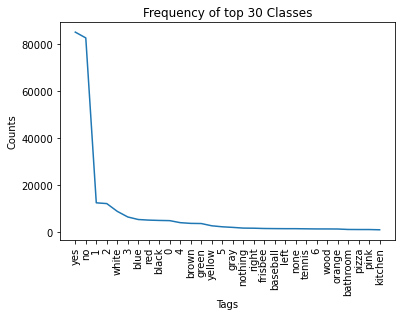

In [9]:
sort_class_frequency = sorted(list(class_frequency.items()), key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

In [10]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)

In [11]:
# take the top 1000 classes
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

# removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [12]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (388252, 1000)
Shape of Answer Vectors in Validation Data:  (214353, 1000)


### Question vectors

In [13]:
def preprocess_question(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
        new_text = new_text + " " + contractions.get(word, word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [14]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_question(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_question(x))

In [15]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)
# val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
# question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])

print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)
# print("Shape of Question Vectors in Validation Data: ", question_vector_val.shape)

Number of words in tokenizer: 12450
Shape of Question Vectors in Train Data:  (388252, 24)


### Image features

In [16]:
image_paths_train = X_train['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  val_imageDirectory + 'COCO_val2014_' + '%012d.jpg' % (x)).values

with open('./all_image_dict.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)
    
with open(dataDirectory + 'val_image_dict.pickle', 'rb') as handle:
    val_image_dict = pickle.load(handle)
    
all_image_dict.update(val_image_dict)
del val_image_dict

In [17]:
list(all_image_dict.values())[0].shape

(1, 7, 7, 512)

### Dataset

In [17]:
model = tf.keras.models.load_model('./final_models/final_baseline_model_50epochs.h5')

In [19]:
# model.summary()

In [21]:
def get_imageTensor(img, ques, qtype, answer,atype,answers):
#     img_tensor = np.load(img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace(".jpg","") + '.npy')
#     img_tensor = np.reshape(img_tensor,(-1,img_tensor.shape[-1]))
    img_tensor = all_image_dict[img.decode('utf-8')]
    img_tensor = tf.squeeze(img_tensor)
    return img_tensor, ques, qtype, answer, atype, answers

def createDataset(image_paths,question_vector,question_type,answer_vector,answer_type,answers):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32), question_type,answer_vector,answer_type,answers))

    # using map to load the numpy files in parallel
    dataset = dataset.map(lambda img, ques, qtype, answer, atype,answers : tf.numpy_function(get_imageTensor, [img, ques, qtype, answer, atype,answers], 
                                                                                     [tf.float32, tf.float32, tf.string, tf.int64, tf.string,tf.string]),
                                      num_parallel_calls = tf.data.experimental.AUTOTUNE)
    # shuffling and batching
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [22]:
image_paths_val = X_val['image_id'].apply(lambda x:  val_imageDirectory + 'COCO_val2014_' + '%012d.jpg' % (x)).values
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)
# answer_vector_val = answer_vector_val.toarray()
answer_type = X_val['answer_type'].values 
answers = X_val['answers'].values

val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=24)

question_type = X_val['question_type'].values 

dataset_val = createDataset(image_paths_val, question_vector_val, question_type, answer_vector_val,answer_type,answers)

In [23]:
len(X_val)/64

3349.265625

In [24]:
error_dict = {  _qtype : { 'top_1' : 0,'top_2' : 0,'top_3' : 0 ,'top_5' : 0,'count' : 0 } for _qtype in np.unique(question_type) }
actual_list = []
pred_list = []

for (batch, (img_tensor, question, qtype, answer,atype,answers)) in tqdm(enumerate(dataset_val)):
    y_pred = model.predict([img_tensor,question])

    for i in range(y_pred.shape[0]):
        _qtype = qtype[i].numpy().decode('utf-8')
        _atype = atype[i].numpy().decode('utf-8')
        error_dict[_qtype]['count'] += 1 
        
        for _k in [1]:#[1,2,3,5]:
            if _atype == 'yes/no' and _k > 1:
                top_k = tf.math.top_k(y_pred, k = 1 ).indices.numpy()[i]
            else:
                top_k = tf.math.top_k(y_pred, k = _k ).indices.numpy()[i]

            pred_classes = np.zeros(y_pred.shape[1])
            pred_classes[top_k] = 1
            actual_list.append(answers[i])
            pred_list.append(pred_classes)
#             if np.dot(pred_classes,answer[i]) > 0:
#                 error_dict[_qtype]['top_' + str(_k)] += 1

3350it [05:13, 10.69it/s]


In [28]:
def model_metric(predictions, truths):
    total = 0
    correct_val = 0.0
    for prediction, truth in tqdm(zip(predictions, truths)):
        truth = ast.literal_eval(truth.numpy().decode('utf-8'))#json.loads(truth.numpy().decode('utf-8').replace("\'", "\""))
        prediction = label_encoder.inverse_transform(np.array([prediction]))[0]
        temp_count = 0
        total += 1
        for _truth in truth:
            if prediction == _truth['answer']:
                temp_count += 1
        # accuracy = min((# humans that provided that answer/3) , 1)
        if temp_count > 2:
            correct_val += 1
        else:
            correct_val += float(temp_count) / 3
    return (correct_val / total)*100

model_metric(pred_list, actual_list)

214353it [00:29, 7291.75it/s]


43.99347493775611